In [ ]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

In [ ]:
#import configuration for selected file
from config import FieldX as field
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [ ]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9

In [ ]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

In [ ]:
#load in the catalog files if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_seg.dat'):
    segTab=ascii.read(field.name+'_'+str(wavelength)+'um_seg.dat')
else:
    segTab=None
    
if os.path.isfile(field.name+'_'+str(wavelength)+'um_dao.dat'):   
    daoTab=ascii.read(field.name+'_'+str(wavelength)+'um_dao.dat')
else:
    daoTab=None

In [ ]:
#Source coordinates need to be in the form of skycoord objects to create apertures. Ascii tables save as strings so this code puts them back in the right form. 
if segTab is not None:
    sourcecoords=segTab['sky_centroid']
else:
    sourcecoords=[]
scseg=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scseg.append(scobj)

if segTab is not None:
    segTab['skycoords']=scseg
    sourcesseg=segTab['skycoords']

sourcecoords=daoTab['sky_centroid']
scdao=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scdao.append(scobj)
    
daoTab['skycoords']=scdao
sourcesdao=daoTab['skycoords']

In [ ]:
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)

if segTab is not None:
    SegPhotTable=performApPhoto(data,wcsmap,sourcesseg,radii,plot=True)

    #display the photometry table
    SegPhotTable
else:
    print('No sources found in segmentation map')

In [ ]:
#example: https://photutils.readthedocs.io/en/stable/psf.html

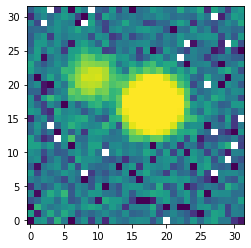

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)
from photutils.background import MMMBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.detection import DAOStarFinder, IRAFStarFinder
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter

sources = Table()
sources['flux'] = [10000, 1000]
sources['x_mean'] = [18, 9]
sources['y_mean'] = [17, 21]
sources['x_stddev'] = [2] * 2
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0] * 2
tshape = (32, 32)
image = (make_gaussian_sources_image(tshape, sources) +
         make_noise_image(tshape, distribution='poisson', mean=6.,
                          seed=123) +
         make_noise_image(tshape, distribution='gaussian', mean=0.,
                          stddev=2., seed=123))

vmin, vmax = np.percentile(image, [5, 95])
plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest',
           origin='lower', norm=LogNorm(vmin=vmin, vmax=vmax))

In [2]:
daogroup = DAOGroup(crit_separation=8)
mmm_bkg = MMMBackground()
iraffind = IRAFStarFinder(threshold=2.5*mmm_bkg(image), fwhm=4.5)
fitter = LevMarLSQFitter()
gaussian_prf = IntegratedGaussianPRF(sigma=2.05)
gaussian_prf.sigma.fixed = False
itr_phot_obj = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                  group_maker=daogroup,
                                                  bkg_estimator=mmm_bkg,
                                                  psf_model=gaussian_prf,
                                                  fitter=fitter,
                                                  fitshape=(11, 11),
                                                  niters=2)

In [5]:
phot_results = itr_phot_obj(image)
phot_results

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,sigma_0,sigma_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,sigma_unc,iter_detected
float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32
18.003510396149217,18.005284165751934,17.001996637752185,17.008150189196392,9424.1257697183,9988.054214012245,2.05,1.978347679925348,1,1,34.44224748648674,0.006875430088399052,0.006875430514250695,0.004938199748737145,1
18.012744828527083,18.006843771267683,16.98812487673021,16.896351342418757,124.47495776908777,256.8430394054114,2.05,1.0952293311837853,1,1,22.9079827859933,0.10108245578194336,0.10108097196079789,0.07397325819095034,2


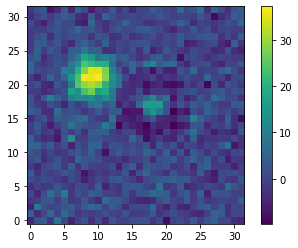

In [7]:
plt.figure()
plt.imshow(itr_phot_obj.get_residual_image(), cmap='viridis', aspect=1, interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

In [18]:
#basic_phot_obj=BasicPSFPhotometry(finder=iraffind,
#                    group_maker=daogroup,
#                    bkg_estimator=mmm_bkg,
#                    psf_model=gaussian_prf,
#                    fitter=fitter,
#                    fitshape=(11, 11))

# See, e.g., DAOStarFinder. If finder is None, initial guesses for positions of objects must be provided.
#https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#basicpsfphotometry

In [23]:
basic_phot_obj=BasicPSFPhotometry(group_maker=daogroup,
                    bkg_estimator=mmm_bkg,
                    psf_model=gaussian_prf,
                    fitter=fitter,
                    fitshape=(11, 11))

In [24]:
photB_results = basic_phot_obj(image)
photB_results

ValueError: Finder cannot be None if init_guesses are not given.

In [20]:
#dir(basic_phot_obj)

In [21]:
photB_results2 = basic_phot_obj.do_photometry(image)
photB_results2

x_0,y_0,flux_0,sigma_0,id,group_id,x_fit,y_fit,flux_fit,sigma_fit,flux_unc,x_0_unc,y_0_unc,sigma_unc
float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64
18.003510396149217,17.001996637752185,9424.1257697183,2.05,1,1,18.005284165751934,17.008150189196392,9988.054214012245,1.978347679925348,34.44224748648674,0.006875430088399052,0.006875430514250695,0.004938199748737145


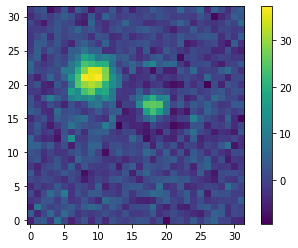

In [22]:
plt.figure()
plt.imshow(basic_phot_obj.get_residual_image(), cmap='viridis', aspect=1, interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()